# Bin Packing Problem With Evolutionary Computations

In [4]:
#from enum import Enum
#from copy import copy, deepcopy
import matplotlib.pyplot as plt
from random import choices, randint, randrange, random, choice
import matplotlib.pyplot as plt
from math import sqrt
from tqdm import tqdm
import numpy as np

In [41]:
## print solution
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle
import plotly.graph_objects as go

# Plot settings
figsize = (6,6)
rect_color = 'lightblue'
edge_color = 'black'
alpha = 0.5

def plot_configuration(configuration, items):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    # Set the ticks for the main plot
    ax.set_xlim([0,BIN_WIDTH])
    ax.set_ylim([0,BIN_HEIGHT])
    ax.set_xticks(range(0, BIN_WIDTH+1, 5))
    ax.set_yticks(range(0, BIN_HEIGHT+1, 5))

    # Draw the placed rects in main plot
    for position, item in zip(configuration, items):
        box = Rectangle(position, item[0], item[1], fc=rect_color, ec=edge_color, alpha=alpha)
        ax.add_patch(box)

    plt.show(block=False)
    plt.title('Best Configuration')
    plt.close()


def plot_fitness(best_fit, worst_fit, n_gen, fit_lim):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.plot(best_fit, label='Best fitness')
    ax.plot(worst_fit, label='Worst fitness')
    ax.hlines(y=fit_lim, xmin=0, xmax=n_gen, colors='black', label='Optimal', linestyles='--')
    ax.set_xlim([0, n_gen])
    #ax.set_ylim([0, fit_lim])
    ax.legend()
    plt.xlabel('Generations')
    plt.ylabel('Fitness')
    plt.title('Fitness Evolution')
    plt.show()


def plot_boxes(ax, boxes_pos, boxes_dim, multi_color):
    for pos, dim in zip(boxes_pos, boxes_dim):
        if multi_color:
            color = "#"+''.join([choice('0123456789ABCDEF') for j in range(6)])
        else:
            color = 'lightblue'
        x, y, z = pos
        dx, dy, dz = dim
        ax.bar3d(x, y, z, dx, dy, dz, shade=True, color=color, edgecolors=edge_color, alpha=alpha)
        
## Plot configuration
def plot_configuration_3d(configuration, items, multi_color=False):


    # Create the 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Set plot limits
    ax.set_xlim([0, BOX_WIDTH])
    ax.set_ylim([0, BOX_HEIGHT])
    ax.set_zlim([0, BOX_DEPTH])

    # Plot the boxes
    plot_boxes(ax, configuration, items, multi_color=multi_color)

    # Set labels
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('3D Bin Packing Solution')

    # Show the plot
    plt.show()


def plot_boxes_interactive(fig, boxes_pos, boxes_dim):
    for pos, dim in zip(boxes_pos, boxes_dim):
        x, y, z = pos
        dx, dy, dz = dim

        #colors = ["#"+''.join([choice('0123456789ABCDEF') for j in range(6)]) for i in range(2)]
        color = "#"+''.join([choice('0123456789ABCDEF') for j in range(6)])
        
        fig.add_trace(go.Mesh3d(x=[x, x, x+dx, x+dx, x, x, x+dx, x+dx],
                                y=[y, y+dy, y+dy, y, y, y+dy, y+dy, y],
                                z=[z, z, z, z, z+dz, z+dz, z+dz, z+dz],
                                #colorscale=[[0, colors[0]],[1, colors[1]]],
                                # Intensity of each vertex, which will be interpolated and color-coded
                                #intensity = np.linspace(0, 1, 8, endpoint=True),
                                # i, j and k give the vertices of triangles
                                i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
                                j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
                                k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
                                name='y',
                                showscale=False,
                                opacity=0.8,
                                color=color,
                                flatshading=True                          
                                ))
        
def plot_configuration_3d_interactive(configuration, items):

    # Create the interactive 3D plot
    fig = go.Figure()

    # Plot the boxes
    plot_boxes_interactive(fig, configuration, items)

    # Set layout
    fig.update_layout(scene=dict(aspectmode="cube",
                                 xaxis=dict(range=[0, BOX_WIDTH]),
                                 yaxis=dict(range=[0, BOX_HEIGHT]),
                                 zaxis=dict(range=[0, BOX_LENGTH]),
                                 aspectratio=dict(x=1, y=1, z=1)))

    # Show the interactive plot
    fig.show()

## 2D Packing Problem - Greed Search

In [6]:
from mip import *
from itertools import permutations

BIN_WIDTH, BIN_HEIGHT = 20, 20

def main(plot=True):

    model = Model()

    W, H = BIN_WIDTH, BIN_HEIGHT
    w, h = list(), list()
    m = list()

    ## Reading instances
    numberOfVariables = 0
    with open('instance_2d.txt') as f:
        for index, line in enumerate(f.readlines()):
            separated_values = line.replace('\n', '').split(',')
            separated_values = [float(value) for value in separated_values]

            if len(separated_values) == 2:
                possible_permutations = set(permutations(separated_values, 2))
                m.append(len(possible_permutations))

                w.append([value[0] for value in possible_permutations])
                h.append([value[1] for value in possible_permutations])

                numberOfVariables += 1

    ## Create variables
    x, y = list(), list()
    s = list()

    left, right, under, over = dict(), dict(), dict(), dict()

    for i in range(numberOfVariables):
        x.append(model.add_var(name=f'x_{i+1}', var_type=CONTINUOUS, lb=0))
        y.append(model.add_var(name=f'y_{i+1}', var_type=CONTINUOUS, lb=0))

        s.append(list())
        for k in range(m[i]):
            s[i].append(model.add_var(name=f's_{i+1}_{k+1}', var_type=BINARY))

        left[i] = dict()
        right[i] = dict()
        under[i] = dict()
        over[i] = dict()

        for j in range(i+1, numberOfVariables):
            left[i][j] = model.add_var(name=f'l_{i+1}_{j+1}', var_type=BINARY)
            right[i][j] = model.add_var(name=f'r_{i+1}_{j+1}', var_type=BINARY)
            under[i][j] = model.add_var(name=f'u_{i+1}_{j+1}', var_type=BINARY)
            over[i][j] = model.add_var(name=f'o_{i+1}_{j+1}', var_type=BINARY)

    ## Create the model
    model.objective = maximize(xsum(s[i][k] for i in range(numberOfVariables) for k in range(m[i])))

    for i in range(numberOfVariables):
        for j in range(i+1, numberOfVariables):
            model += left[i][j] + right[i][j] + under[i][j] + over[i][j] >= xsum(s[i][k] for k in range(m[i])) + xsum(s[j][k] for k in range(m[j])) - 1
            model += left[i][j] + right[i][j] + under[i][j] + over[i][j] <= xsum(s[i][k] for k in range(m[i]))
            model += left[i][j] + right[i][j] + under[i][j] + over[i][j] <= xsum(s[j][k] for k in range(m[j]))

            model += x[i] - x[j] + W * left[i][j] <= W - xsum(s[i][k] * w[i][k] for k in range(m[i]))
            model += x[j] - x[i] + W * right[i][j] <= W - xsum(s[j][k] * w[j][k] for k in range(m[j]))
            model += y[i] - y[j] + H * under[i][j] <= H - xsum(s[i][k] * h[i][k] for k in range(m[i]))
            model += y[j] - y[i] + H * over[i][j] <= H - xsum(s[j][k] * h[j][k] for k in range(m[j]))
        
        model += xsum(s[i][k] for k in range(m[i])) == 1

    for i in range(numberOfVariables):
        model += x[i] <= W - xsum(s[i][k] * w[i][k] for k in range(m[i]))
        model += y[i] <= H - xsum(s[i][k] * h[i][k] for k in range(m[i]))

    ## Solving
    model.max_gap = 0.05
    status = model.optimize(max_seconds=600)

    positions = []
    orientations = []

    if status == OptimizationStatus.OPTIMAL:
        print(f'solution: {model.objective_value}')
        items_orientation = dict()
        for v in model.vars:
            if v.name[0] == "s" and v.x >= 0.98:
                sep_name = v.name.split("_")
                item_name = f"Item {sep_name[1]}"

                items_orientation[item_name] = list()

                items_orientation[item_name].append(w[int(sep_name[1])-1][int(sep_name[2])-1])
                items_orientation[item_name].append(h[int(sep_name[1])-1][int(sep_name[2])-1])

        print("Items:")
        position = []
        for index, v in enumerate(model.vars):
            
            if v.name[0] == "x":
                sep_name = v.name.split("_")
                print(f"\tItem {sep_name[1]}:")
                print(f"\t\tposition: [{v.x}, ", end="")
                position.append(v.x)
            elif v.name[0] == "y":
                print(f"{v.x}],")
                position.append(v.x)
                positions.append(position)
                position = []
                sep_name = v.name.split("_")
                print(f"\t\torientation: {items_orientation[f'Item {sep_name[1]}']}")
                orientations.append(items_orientation[f'Item {sep_name[1]}'])


        print("boxes_dimensions = ", end="")
        print(orientations)
        print("boxes_positions = ", end="")
        print(positions)

        if plot:
            plot_configuration(positions, orientations)
        #model.write("3DPacking.lp")
    elif status == OptimizationStatus.INFEASIBLE:
        print('The Problem is INFEASIBLE')

solution: 14.0
Items:
	Item 1:
		position: [0.0, 8.0],
		orientation: [2.0, 12.0]
	Item 2:
		position: [8.0, 0.0],
		orientation: [12.0, 7.0]
	Item 3:
		position: [8.0, 14.0],
		orientation: [8.0, 6.0]
	Item 4:
		position: [2.0, 7.0],
		orientation: [3.0, 6.0]
	Item 5:
		position: [5.0, 12.0],
		orientation: [3.0, 5.0]
	Item 6:
		position: [11.0, 7.0],
		orientation: [5.0, 5.0]
	Item 7:
		position: [5.0, 0.0],
		orientation: [3.0, 12.0]
	Item 8:
		position: [17.0, 7.0],
		orientation: [3.0, 7.0]
	Item 9:
		position: [0.0, 0.0],
		orientation: [5.0, 7.0]
	Item 10:
		position: [8.0, 12.0],
		orientation: [6.0, 2.0]
	Item 11:
		position: [14.0, 12.0],
		orientation: [3.0, 2.0]
	Item 12:
		position: [16.0, 18.0],
		orientation: [4.0, 2.0]
	Item 13:
		position: [2.0, 17.0],
		orientation: [4.0, 3.0]
	Item 14:
		position: [16.0, 14.0],
		orientation: [4.0, 4.0]
boxes_dimensions = [[2.0, 12.0], [12.0, 7.0], [8.0, 6.0], [3.0, 6.0], [3.0, 5.0], [5.0, 5.0], [3.0, 12.0], [3.0, 7.0], [5.0, 7.0], [

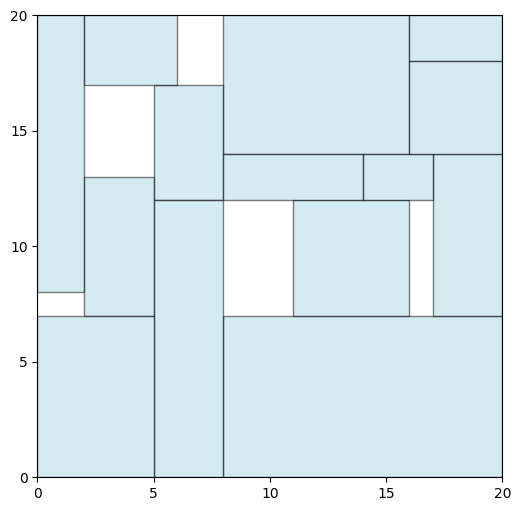

In [7]:
main()

## Genetic algorithms from scratch

**NEED**
- configuration to represent an individual(solution)
- Mutation function
- Crossover function
- Selection
- Fitness function

In [11]:
BIN_WIDTH = 20
BIN_HEIGHT = 20


def generate_items(n):
    return [(randrange(1,BIN_WIDTH//3), randrange(1,BIN_HEIGHT//3)) for _ in range(n)]

items = [(2,12),(7,12),(8,6),(3,6),(3,5),(5,5),(3,12),(3,7),(5,7),(2,6),(3,2),(4,2),(3,4),(4,4)]
#items = [(2,12),(7,12),(8,6),(3,6),(3,5),(5,5),(3,12),(3,7),(5,7),(2,6),(3,2),(4,2)]

In [17]:
def items_oriented(genome, items):
    new_items = []
    for item, gene in zip(items, genome):
        if gene[2] == 0:
            new_items.append(item)
        elif gene[2] == 1:
            new_items.append((item[1], item[0]))
    return new_items

def generate_genome(items):
    candidate = []

    for obj in items:
        # Each object has x, y, width, height as decision variables
        r = randint(0,1)
        if r == 0: ## No rotation
            x = randint(0, BIN_WIDTH - obj[0])
            y = randint(0, BIN_HEIGHT - obj[1])
        elif r == 1: ## Rotation
            x = randint(0, BIN_WIDTH - obj[1])
            y = randint(0, BIN_HEIGHT - obj[0])
        candidate.append((x, y, r))
    return candidate

def generate_population(size: int, items):
    return [generate_genome(items) for _ in range(size)]

## Fitness using Matrix vectorization (Maximization problem)
def fitness(genome, items):
    items_cpy = items_oriented(genome, items)

    sol_space = np.zeros((BIN_WIDTH, BIN_HEIGHT), dtype=np.int32)

    for gene, item in zip(genome, items_cpy):
        sol_space[gene[0]:gene[0]+item[0], gene[1]:gene[1]+item[1]] += 1

    good_pos = np.where(sol_space == 1) ## the more space they occupy the better the fitness
    good_fit = len(sol_space[good_pos])

    bad_pos = np.where(sol_space > 1) ## penalty function for overlapped area
    bad_fit = len(sol_space[bad_pos])

    return (good_fit - bad_fit)

## Selection for Maximization
def selection_pair(population, n_parents : int = 2): ## Roulette-wheel selection
    return choices(population=population,
                   weights=[fitness(genome, items) for genome in population],
                   k=n_parents)

def single_point_crossover(a, b):
    assert len(a) == len(b), 'Genomes must have the same length'

    length = len(a)
    if length < 2:
        return a, b
    
    p = randint(1, length - 1)
    return a[0:p] + b[p:], b[0:p] + a[p:]

def mutation(genome, items, num: int = 1, probability: float = 0.5):
    for _ in range(num):
        index = randrange(len(genome))
        if random() <= probability:
            r = randint(0,1)
            if r == 0:
                x = randint(0, BIN_WIDTH - items[index][0])
                y = randint(0, BIN_HEIGHT - items[index][1])
            elif r == 1:
                x = randint(0, BIN_WIDTH - items[index][1])
                y = randint(0, BIN_HEIGHT - items[index][0])
            genome[index] = (x, y, r)
    return genome

def run_evolution(pop_size=100, generation_limit: int = 100, num_mutation = 1, mutation_probability=0.5, n_elites=2):
    
    fitness_limit = sum([item[0]*item[1] for item in items])

    population = generate_population(pop_size, items=items)
    best_fitnesses = []
    worst_fitnesses = []

    for i in tqdm(range(generation_limit)):
        population = sorted(population, key=lambda genome: fitness(genome, items), reverse=True)

        best_fitnesses.append(fitness(population[0], items))
        worst_fitnesses.append(fitness(population[-1], items))
        
        if fitness(population[0], items) == fitness_limit:
            print('All items can fit perfectly in the bin!')
            break
        
        next_generation = population[0:n_elites] ## Elitism

        for j in range(int(len(population) /2) - (n_elites//2)):
            parents = selection_pair(population)
            offspring_a, offspring_b = single_point_crossover(parents[0], parents[1])
            offspring_a = mutation(offspring_a, items, num=num_mutation, probability=mutation_probability)
            offspring_b = mutation(offspring_b, items, num=num_mutation, probability=mutation_probability)
            next_generation += [offspring_a, offspring_b]
        
        population = next_generation

    population = sorted(population, key=lambda genome: fitness(genome, items), reverse=True)
    best_fitness = fitness(population[0], items)
    best_fitnesses.append(best_fitness)
    worst_fitnesses.append(fitness(population[-1], items))
    
    return population, i, best_fitness, best_fitnesses, worst_fitnesses, fitness_limit

def plot_configuration_with_rotation(configuration, items):
    dimensions = [(conf[0], conf[1]) for conf in configuration]
    new_items = items_oriented(configuration, items)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    # Set the ticks for the main plot
    ax.set_xlim([0,BIN_WIDTH])
    ax.set_ylim([0,BIN_HEIGHT])
    ax.set_xticks(range(0, BIN_WIDTH+1, 5))
    ax.set_yticks(range(0, BIN_HEIGHT+1, 5))

    # Draw the placed rects in main plot
    for position, item in zip(dimensions, new_items):
        box = Rectangle(position, item[0], item[1], fc=rect_color, ec=edge_color, alpha=alpha)
        ax.add_patch(box)

    plt.show(block=False)
    plt.title('Best Configuration')
    plt.close()

100%|██████████| 1000/1000 [03:40<00:00,  4.53it/s]

number of generations:  999
items:  [(2, 12), (7, 12), (8, 6), (3, 6), (3, 5), (5, 5), (3, 12), (3, 7), (5, 7), (2, 6), (3, 2), (4, 2), (3, 4), (4, 4)]
best solution:  [(18, 3, 0), (11, 0, 0), (0, 11, 1), (15, 13, 0), (9, 0, 0), (0, 5, 0), (6, 0, 0), (1, 1, 1), (10, 13, 0), (9, 11, 1), (9, 8, 1), (18, 15, 1), (6, 12, 0), (7, 16, 0)]
maximum fitness =  360
best fitness:  303


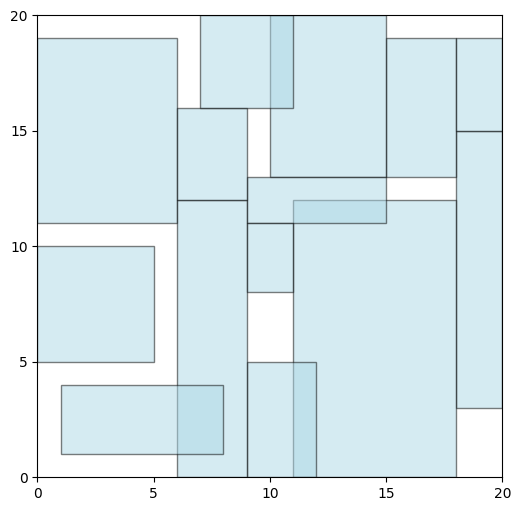

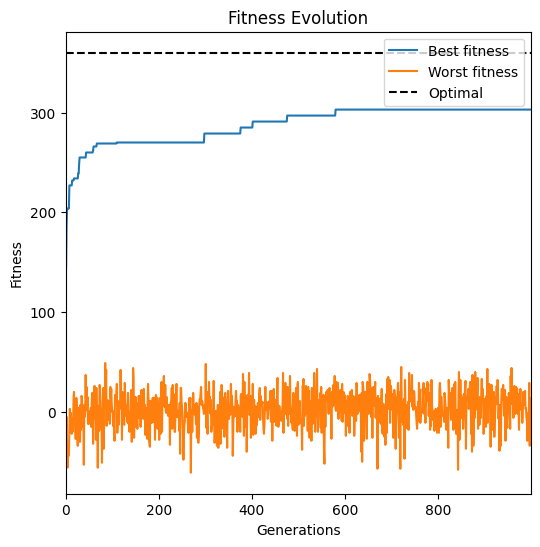

In [19]:
population, generations, fit, best_fits, worst_fits, fit_lim = run_evolution(generation_limit=1000, num_mutation=3, mutation_probability=0.5, n_elites=2)

print('number of generations: ', generations)
print('items: ', items)
print('best solution: ', population[0])
print('maximum fitness = ',fit_lim)
print('best fitness: ', fit)
plot_configuration(population[0], items)
plot_fitness(best_fits, worst_fits, generations, fit_lim)

In [9]:
def generate_genome(items):
    candidate = []

    for obj in items:
        # Each object has x, y, width, height as decision variables
        x = randint(0, BIN_WIDTH - obj[0])
        y = randint(0, BIN_HEIGHT - obj[1])
        candidate.append((x, y))
    return candidate

def generate_population(size: int, items):
    return [generate_genome(items) for _ in range(size)]

## Fitness using Matrix vectorization (Maximization problem)
def fitness(genome, items):
    sol_space = np.zeros((BIN_WIDTH, BIN_HEIGHT), dtype=np.int32)

    for gene, item in zip(genome, items):
        sol_space[gene[0]:gene[0]+item[0], gene[1]:gene[1]+item[1]] += 1

    good_pos = np.where(sol_space == 1) ## the more space they occupy the better the fitness
    good_fit = len(sol_space[good_pos])

    bad_pos = np.where(sol_space > 1) ## penalty function for overlapped area
    bad_fit = len(sol_space[bad_pos])

    return (good_fit - bad_fit) 

## Selection for Maximization
def selection_pair(population, n_parents : int = 2): ## Roulette-wheel selection
    return choices(population=population,
                   weights=[fitness(genome, items) for genome in population],
                   k=n_parents)

def single_point_crossover(a, b):
    assert len(a) == len(b), 'Genomes must have the same length'

    length = len(a)
    if length < 2:
        return a, b
    
    p = randint(1, length - 1)
    return a[0:p] + b[p:], b[0:p] + a[p:]

def mutation(genome, items, num: int = 1, probability: float = 0.5):
    for _ in range(num):
        index = randrange(len(genome))
        if random() <= probability:
            x = randint(0, BIN_WIDTH - items[index][0])
            y = randint(0, BIN_HEIGHT - items[index][1])
            genome[index] = (x, y)
    return genome

def run_evolution(pop_size=100, generation_limit: int = 100, num_mutation = 1, mutation_probability=0.5, n_elites=2):
    
    fitness_limit = sum([item[0]*item[1] for item in items])

    population = generate_population(pop_size, items=items)
    best_fitnesses = []
    worst_fitnesses = []

    for i in tqdm(range(generation_limit)):
        population = sorted(population, key=lambda genome: fitness(genome, items), reverse=True)

        best_fitnesses.append(fitness(population[0], items))
        worst_fitnesses.append(fitness(population[-1], items))
        
        if fitness(population[0], items) == fitness_limit:
            print('All items can fit perfectly in the bin!')
            break
        
        next_generation = population[0:n_elites] ## Elitism

        for j in range(int(len(population) /2) - (n_elites//2)):
            parents = selection_pair(population)
            offspring_a, offspring_b = single_point_crossover(parents[0], parents[1])
            offspring_a = mutation(offspring_a, items, num=num_mutation, probability=mutation_probability)
            offspring_b = mutation(offspring_b, items, num=num_mutation, probability=mutation_probability)
            next_generation += [offspring_a, offspring_b]
        
        population = next_generation

    population = sorted(population, key=lambda genome: fitness(genome, items), reverse=True)
    best_fitness = fitness(population[0], items)
    best_fitnesses.append(best_fitness)
    worst_fitnesses.append(fitness(population[-1], items))
    
    return population, i, best_fitness, best_fitnesses, worst_fitnesses, fitness_limit

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [03:26<00:00,  4.84it/s]

number of generations:  999
items:  [(2, 12), (7, 12), (8, 6), (3, 6), (3, 5), (5, 5), (3, 12), (3, 7), (5, 7), (2, 6), (3, 2), (4, 2), (3, 4), (4, 4)]
best solution:  [(0, 1), (9, 0), (11, 14), (6, 3), (6, 15), (3, 9), (17, 0), (8, 12), (0, 13), (2, 3), (6, 1), (11, 12), (15, 10), (2, 0)]
maximum fitness =  360
best fitness:  324


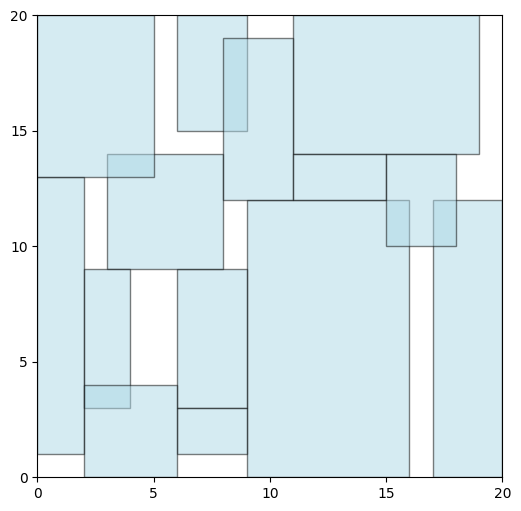

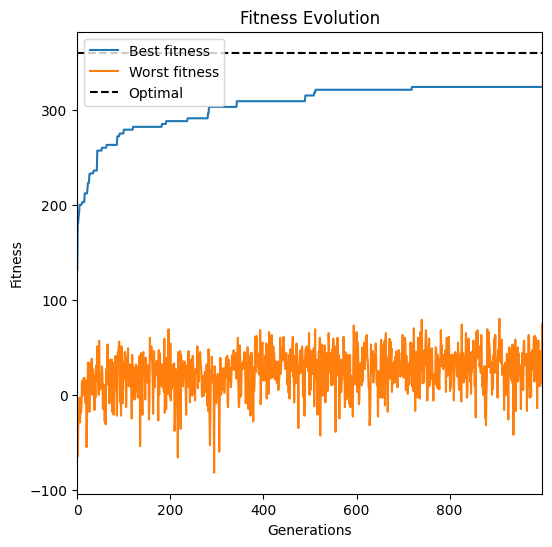

In [10]:
population, generations, fit, best_fits, worst_fits, fit_lim = run_evolution(generation_limit=1000, num_mutation=2, mutation_probability=0.5, n_elites=2)

print('number of generations: ', generations)
print('items: ', items)
print('best solution: ', population[0])
print('maximum fitness = ',fit_lim)
print('best fitness: ', fit)
plot_configuration(population[0], items)
plot_fitness(best_fits, worst_fits, generations, fit_lim)

 46%|████▌     | 69/150 [00:12<00:14,  5.52it/s]


All items can fit perfectly in the bin!


100%|██████████| 150/150 [00:41<00:00,  3.58it/s]


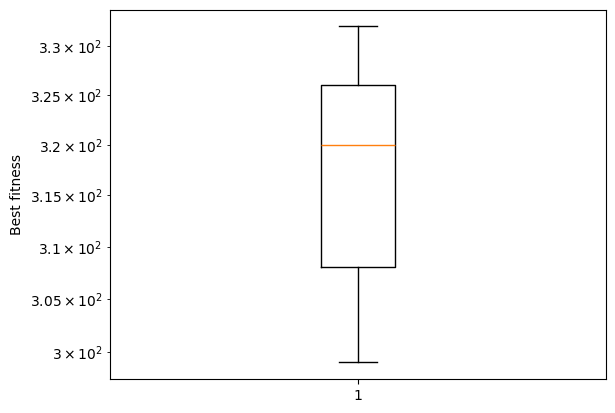

In [47]:
## Multiple runs
n_runs = 20
best_fitnesses = []
for _ in range(n_runs):
    _,_,best_fitness,_,_,_ = run_evolution(generation_limit=150, num_mutation=1, mutation_probability=0.5, n_elites=2)
    best_fitnesses.append(best_fitness)


fig = plt.figure('GA (best fitness)')
ax = fig.gca()
ax.boxplot([best_fitnesses], notch=False)
#ax.set_xticklabels(['Mutation only'])
ax.set_yscale('log')
#ax.set_xlabel('Condition')
ax.set_ylabel('Best fitness')
plt.show()

 79%|███████▉  | 79/100 [00:13<00:03,  5.76it/s]


All items can fit perfectly in the bin!


100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


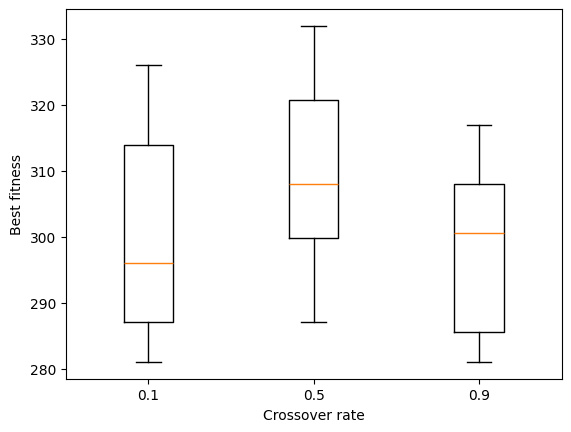

In [48]:
## Fine-tuning mutation
n_runs = 10
mutation_rates = [0.1, 0.5, 0.9] # mutation rates

best_fitnesses = []
for mutation_rate in mutation_rates:
    fitnesses_each_mutation = []
    for _ in range(n_runs):
        _,_,best_fitness,_,_,_ = run_evolution(generation_limit=100, num_mutation=1, mutation_probability=mutation_rate, n_elites=2)
        fitnesses_each_mutation.append(best_fitness)
    best_fitnesses.append(fitnesses_each_mutation)

fig = plt.figure('GA (best fitness)')
ax = fig.gca()
ax.boxplot(best_fitnesses,notch=False)
ax.set_xticklabels(mutation_rates)
ax.set_xlabel('Mutation rate')
ax.set_ylabel('Best fitness')
plt.show()

## 3D Bin Packing - Greed Search

In [8]:
from mip import *
from itertools import permutations

BOX_WIDTH, BOX_HEIGHT, BOX_DEPTH = 3, 3, 3

def main(plot=True):

    model = Model()

    W, H, D = BOX_WIDTH, BOX_HEIGHT, BOX_DEPTH
    w, h, d = list(), list(), list()
    m = list()

    ## Reading instances
    #numberOfVariables = -1
    numberOfVariables = 0
    with open('instance.txt') as f:
        for index, line in enumerate(f.readlines()):
            separated_values = line.replace('\n', '').split(',')
            separated_values = [float(value) for value in separated_values]

            if len(separated_values) == 3:
                #if index == 0:
                #    W = float(separated_values[0])
                #    H = float(separated_values[1])
                #    D = float(separated_values[2])
                #else:
                possible_permutations = set(permutations(separated_values, 3))
                m.append(len(possible_permutations))

                w.append([value[0] for value in possible_permutations])
                h.append([value[1] for value in possible_permutations])
                d.append([value[2] for value in possible_permutations])

                numberOfVariables += 1

    ## Create variables
    x, y, z = list(), list(), list()
    s = list()

    left, right, under, over, behind, infront = dict(), dict(), dict(), dict(), dict(), dict()

    for i in range(numberOfVariables):
        x.append(model.add_var(name=f'x_{i+1}', var_type=CONTINUOUS, lb=0))
        y.append(model.add_var(name=f'y_{i+1}', var_type=CONTINUOUS, lb=0))
        z.append(model.add_var(name=f'z_{i+1}', var_type=CONTINUOUS, lb=0))

        s.append(list())
        for k in range(m[i]):
            s[i].append(model.add_var(name=f's_{i+1}_{k+1}', var_type=BINARY))

        left[i] = dict()
        right[i] = dict()
        under[i] = dict()
        over[i] = dict()
        behind[i] = dict()
        infront[i] = dict()

        for j in range(i+1, numberOfVariables):
            left[i][j] = model.add_var(name=f'l_{i+1}_{j+1}', var_type=BINARY)
            right[i][j] = model.add_var(name=f'r_{i+1}_{j+1}', var_type=BINARY)
            under[i][j] = model.add_var(name=f'u_{i+1}_{j+1}', var_type=BINARY)
            over[i][j] = model.add_var(name=f'o_{i+1}_{j+1}', var_type=BINARY)
            behind[i][j] = model.add_var(name=f'b_{i+1}_{j+1}', var_type=BINARY)
            infront[i][j] = model.add_var(name=f'f_{i+1}_{j+1}', var_type=BINARY)

    ## Create the model
    model.objective = maximize(xsum(s[i][k] for i in range(numberOfVariables) for k in range(m[i])))

    for i in range(numberOfVariables):
        for j in range(i+1, numberOfVariables):
            model += left[i][j] + right[i][j] + under[i][j] + over[i][j] + behind[i][j] + infront[i][j] >= xsum(s[i][k] for k in range(m[i])) + xsum(s[j][k] for k in range(m[j])) - 1
            model += left[i][j] + right[i][j] + under[i][j] + over[i][j] + behind[i][j] + infront[i][j] <= xsum(s[i][k] for k in range(m[i]))
            model += left[i][j] + right[i][j] + under[i][j] + over[i][j] + behind[i][j] + infront[i][j] <= xsum(s[j][k] for k in range(m[j]))

            model += x[i] - x[j] + W * left[i][j] <= W - xsum(s[i][k] * w[i][k] for k in range(m[i]))
            model += x[j] - x[i] + W * right[i][j] <= W - xsum(s[j][k] * w[j][k] for k in range(m[j]))
            model += y[i] - y[j] + H * under[i][j] <= H - xsum(s[i][k] * h[i][k] for k in range(m[i]))
            model += y[j] - y[i] + H * over[i][j] <= H - xsum(s[j][k] * h[j][k] for k in range(m[j]))
            model += z[i] - z[j] + D * behind[i][j] <= D - xsum(s[i][k] * d[i][k] for k in range(m[i]))
            model += z[j] - z[i] + D * infront[i][j] <= D - xsum(s[j][k] * d[j][k] for k in range(m[j]))
        
        model += xsum(s[i][k] for k in range(m[i])) == 1

    for i in range(numberOfVariables):
        model += x[i] <= W - xsum(s[i][k] * w[i][k] for k in range(m[i]))
        model += y[i] <= H - xsum(s[i][k] * h[i][k] for k in range(m[i]))
        model += z[i] <= D - xsum(s[i][k] * d[i][k] for k in range(m[i]))

    ## Solving
    model.max_gap = 0.05
    status = model.optimize(max_seconds=600)

    positions = []
    orientations = []

    if status == OptimizationStatus.OPTIMAL:
        print(f'solution: {model.objective_value}')
        items_orientation = dict()
        for v in model.vars:
            if v.name[0] == "s" and v.x >= 0.98:
                sep_name = v.name.split("_")
                item_name = f"Item {sep_name[1]}"

                items_orientation[item_name] = list()

                items_orientation[item_name].append(w[int(sep_name[1])-1][int(sep_name[2])-1])
                items_orientation[item_name].append(h[int(sep_name[1])-1][int(sep_name[2])-1])
                items_orientation[item_name].append(d[int(sep_name[1])-1][int(sep_name[2])-1])

        print("Items:")
        position = []
        for index, v in enumerate(model.vars):
            
            if v.name[0] == "x":
                sep_name = v.name.split("_")
                print(f"\tItem {sep_name[1]}:")
                # print(f"\t\tposition: [{round(v.x/unit)}, ", end="")
                print(f"\t\tposition: [{v.x}, ", end="")
                position.append(v.x)
            elif v.name[0] == "y":
                print(f"{v.x}, ", end="")
                position.append(v.x)
            elif v.name[0] == "z":
                print(f"{v.x}],")
                position.append(v.x)
                positions.append(position)
                position = []
                sep_name = v.name.split("_")
                print(f"\t\torientation: {items_orientation[f'Item {sep_name[1]}']}")
                orientations.append(items_orientation[f'Item {sep_name[1]}'])


        print("boxes_dimensions = ", end="")
        print(orientations)
        print("boxes_positions = ", end="")
        print(positions)

        if plot:
            plot_configuration_3d(positions, orientations, multi_color=True)
        #model.write("3DPacking.lp")
    elif status == OptimizationStatus.INFEASIBLE:
        print('The Problem is INFEASIBLE')

solution: 15.0
Items:
	Item 1:
		position: [2.0, 2.0, 0.0],
		orientation: [1.0, 1.0, 3.0]
	Item 2:
		position: [1.0, 0.0, 2.0],
		orientation: [1.0, 3.0, 1.0]
	Item 3:
		position: [0.0, 2.0, 0.0],
		orientation: [1.0, 1.0, 3.0]
	Item 4:
		position: [1.0, 1.0, 0.0],
		orientation: [1.0, 1.0, 1.0]
	Item 5:
		position: [0.0, 0.0, 2.0],
		orientation: [1.0, 1.0, 1.0]
	Item 6:
		position: [2.0, 1.0, 2.0],
		orientation: [1.0, 1.0, 1.0]
	Item 7:
		position: [2.0, 0.0, 2.0],
		orientation: [1.0, 1.0, 1.0]
	Item 8:
		position: [0.0, 1.0, 2.0],
		orientation: [1.0, 1.0, 1.0]
	Item 9:
		position: [1.0, 0.0, 0.0],
		orientation: [1.0, 1.0, 1.0]
	Item 10:
		position: [1.0, 2.0, 0.0],
		orientation: [1.0, 1.0, 2.0]
	Item 11:
		position: [0.0, 0.0, 0.0],
		orientation: [1.0, 2.0, 1.0]
	Item 12:
		position: [2.0, 0.0, 0.0],
		orientation: [1.0, 2.0, 1.0]
	Item 13:
		position: [2.0, 0.0, 1.0],
		orientation: [1.0, 2.0, 1.0]
	Item 14:
		position: [0.0, 1.0, 1.0],
		orientation: [2.0, 1.0, 1.0]
	Item 1

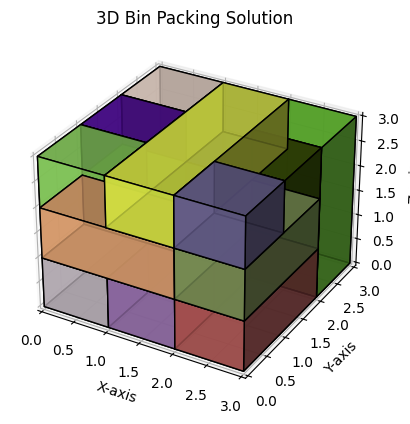

In [9]:
main()

## 3D Bin Packing - Genetic Algorithms

In [26]:
BOX_WIDTH = 3
BOX_HEIGHT = 3
BOX_DEPTH = 3


def generate_items_3d(n):
    return [(randrange(1,BOX_WIDTH//3), randrange(1,BOX_HEIGHT//3), randrange(1,BOX_DEPTH//3)) for _ in range(n)]

#items = [(2,12,3),(7,12,4),(8,6,6),(3,6,2),(3,5,5),(5,5,3),(3,12,4),(3,7,4),(5,7,8),(2,6,9),(3,2,11),(4,2,7),(7,8,2),(10,3,8),(7,12,4),(8,6,6),(3,6,2)]
items = [(3, 1, 1),
    (3, 1, 1),
    (3, 1, 1),
    (1, 1, 1),
    (1, 1, 1),
    (1, 1, 1),
    (1, 1, 1),
    (1, 1, 1),
    (1, 1, 1),
    (2, 1, 1),
    (2, 1, 1),
    (2, 1, 1),
    (2, 1, 1),
    (2, 1, 1),
    (2, 1, 1)]

In [27]:
def items_oriented_3d(genome, items):
    new_items = []
    for item, gene in zip(items, genome):
        w,h,d = item

        if gene[3] == 1:
            h = item[2]
            d = item[1]
        if gene[4] == 1:
            w = item[2]
            d = item[0]
        if gene[5] == 1:
            w = item[1]
            h = item[0]

        new_items.append((w,h,d))
    return new_items

def generate_genome(items):
    candidate = []

    for obj in items:
        w,h,d = obj

        rx = randint(0,1) ## swap y with z
        ry = randint(0,1) ## swap x with z
        rz = randint(0,1) ## swap x with y

        if rx == 1:
            h = obj[2]
            d = obj[1]
        if ry == 1:
            w = obj[2]
            d = obj[0]
        if rz == 1:
            w = obj[1]
            h = obj[0]

        # Each object has width, height and depth as decision variables
        x = randint(0, BOX_WIDTH - w)
        y = randint(0, BOX_HEIGHT - h)
        z = randint(0, BOX_DEPTH - d)
        candidate.append((x, y, z, rx, ry, rz))
    return candidate

def generate_population(size: int, items):
    return [generate_genome(items) for _ in range(size)]

## Fitness using Matrix vectorization (Maximization problem)
def fitness(genome, items):
    new_items = items_oriented_3d(genome, items)
    sol_space = np.zeros((BOX_WIDTH, BOX_HEIGHT, BOX_DEPTH), dtype=np.int32)

    for gene, item in zip(genome, new_items):
        sol_space[gene[0]:gene[0]+item[0], gene[1]:gene[1]+item[1], gene[2]:gene[2]+item[2]] += 1

    good_pos = np.where(sol_space == 1) ## the more space they occupy the better the fitness
    good_fit = len(sol_space[good_pos])

    bad_pos = np.where(sol_space > 1) ## penalty function for overlapped area
    bad_fit = len(sol_space[bad_pos])

    return (good_fit - bad_fit)

## Selection for Maximization
def selection_pair(population, n_parents : int = 2):
    return choices(population=population, weights=[fitness(genome, items) for genome in population], k=n_parents)

def single_point_crossover(a, b):
    assert len(a) == len(b), 'Genomes must have the same length'

    length = len(a)
    if length < 2:
        return a, b
    
    p = randint(1, length - 1)
    return a[0:p] + b[p:], b[0:p] + a[p:]

def mutation(genome, items, num: int = 1, probability: float = 0.5):
    for _ in range(num):
        index = randrange(len(genome))
        if random() <= probability:
            rx, ry, rz = randint(0,1), randint(0,1), randint(0,1)
            w,h,d = items[index]
            if rx == 1:
                h = items[index][2]
                d = items[index][1]
            if ry == 1:
                w = items[index][2]
                d = items[index][0]
            if rz == 1:
                w = items[index][1]
                h = items[index][0]
            x = randint(0, BOX_WIDTH - w)
            y = randint(0, BOX_HEIGHT - h)
            z = randint(0, BOX_DEPTH - d)
            genome[index] = (x, y, z, rx, ry, rz)
    return genome

def run_evolution(pop_size=100, generation_limit: int = 100, num_mutation = 1, mutation_probability=0.5):
    
    fitness_limit = sum([item[0]*item[1]*item[2] for item in items])

    population = generate_population(pop_size, items=items)
    best_fitnesses, worst_fitnesses = [], []

    for i in tqdm(range(generation_limit)):
        population = sorted(population, key=lambda genome: fitness(genome, items), reverse=True)
        best_fitnesses.append(fitness(population[0], items))
        worst_fitnesses.append(fitness(population[-1], items))
        
        if fitness(population[0], items) == fitness_limit:
            print('All items can fit perfectly in the box!')
            break
        
        next_generation = population[0:2] ## Elitism

        for j in range(int(len(population) /2) - 1):
            parents = selection_pair(population)
            offspring_a, offspring_b = single_point_crossover(parents[0], parents[1])
            offspring_a = mutation(offspring_a, items, num=num_mutation, probability=mutation_probability)
            offspring_b = mutation(offspring_b, items, num=num_mutation, probability=mutation_probability)
            next_generation += [offspring_a, offspring_b]
        
        population = next_generation

    population = sorted(population, key=lambda genome: fitness(genome, items), reverse=True)
    best_fitness = fitness(population[0], items)
    best_fitnesses.append(best_fitness)
    worst_fitnesses.append(fitness(population[-1], items))
    
    return population, i, best_fitness, best_fitnesses, worst_fitnesses, fitness_limit

def plot_boxes(ax, boxes_pos, boxes_dim, multi_color):
    for pos, dim in zip(boxes_pos, boxes_dim):
        if multi_color:
            color = "#"+''.join([choice('0123456789ABCDEF') for j in range(6)])
        else:
            color = 'lightblue'
        x, y, z = pos
        dx, dy, dz = dim
        ax.bar3d(x, y, z, dx, dy, dz, shade=True, color=color, edgecolors=edge_color, alpha=alpha)
        
## Plot configuration
def plot_configuration_3d(configuration, items, multi_color=False):
    dimensions = [(conf[0], conf[1], conf[2]) for conf in configuration]
    new_items = items_oriented_3d(configuration, items)

    # Create the 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Set plot limits
    ax.set_xlim([0, BOX_WIDTH])
    ax.set_ylim([0, BOX_HEIGHT])
    ax.set_zlim([0, BOX_DEPTH])

    # Plot the boxes
    plot_boxes(ax, dimensions, new_items, multi_color=multi_color)

    # Set labels
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('3D Bin Packing Solution')

    # Show the plot
    plt.show()

 54%|█████▍    | 108/200 [00:05<00:04, 21.57it/s]


All items can fit perfectly in the box!
number of generations:  108
items:  [(3, 1, 1), (3, 1, 1), (3, 1, 1), (1, 1, 1), (1, 1, 1), (1, 1, 1), (1, 1, 1), (1, 1, 1), (1, 1, 1), (2, 1, 1), (2, 1, 1), (2, 1, 1), (2, 1, 1), (2, 1, 1), (2, 1, 1)]
best solution:  [(1, 0, 2, 1, 0, 1), (0, 0, 0, 1, 1, 0), (2, 0, 0, 0, 0, 1), (0, 2, 1, 0, 0, 0), (0, 2, 0, 1, 0, 1), (0, 2, 2, 0, 0, 0), (1, 0, 1, 1, 1, 1), (0, 1, 0, 0, 1, 1), (1, 0, 0, 0, 0, 0), (2, 1, 2, 0, 0, 1), (1, 1, 0, 1, 0, 1), (0, 1, 1, 0, 1, 0), (2, 1, 1, 1, 0, 1), (1, 1, 1, 1, 0, 1), (2, 0, 1, 1, 1, 0)]
best fitness:  27
maximum fitness =  27


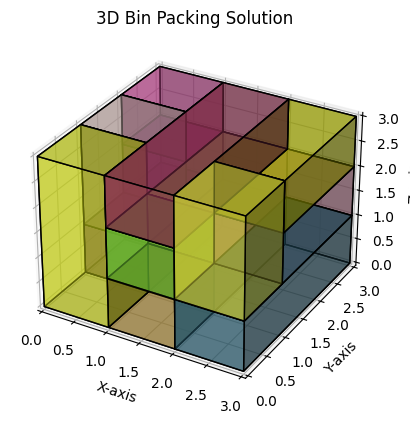

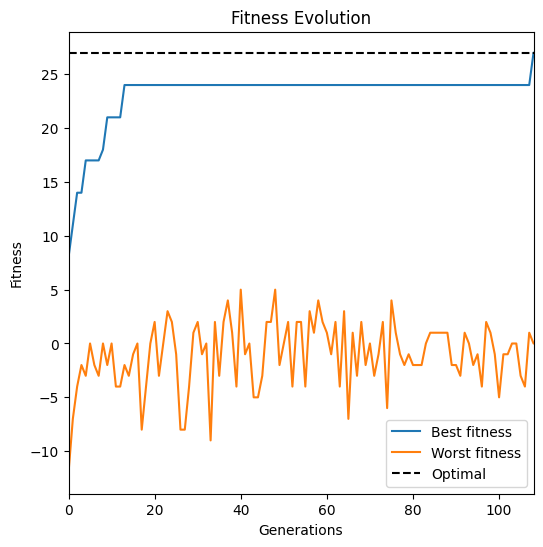

In [28]:
population, generations, fit, best_fits, worst_fits, fit_lim = run_evolution(pop_size=50, generation_limit=200, num_mutation=2, mutation_probability=0.5)

print('number of generations: ', generations)
print('items: ', items)
print('best solution: ', population[0])
print('best fitness: ', fit)
print('maximum fitness = ',fit_lim)
plot_configuration_3d(population[0], items, multi_color=True)
plot_fitness(best_fits, worst_fits, generations, fit_lim)

In [31]:
def generate_genome(items):
    candidate = []

    for obj in items:
        # Each object has x, y, width, height as decision variables
        x = randint(0, BOX_WIDTH - obj[0])
        y = randint(0, BOX_HEIGHT - obj[1])
        z = randint(0, BOX_DEPTH - obj[2])
        candidate.append((x, y, z))
    return candidate

def generate_population(size: int, items):
    return [generate_genome(items) for _ in range(size)]


## Fitness using Matrix vectorization (Maximization problem)
def fitness(genome, items):
    sol_space = np.zeros((BOX_WIDTH, BOX_HEIGHT, BOX_DEPTH), dtype=np.int32)

    for gene, item in zip(genome, items):
        sol_space[gene[0]:gene[0]+item[0], gene[1]:gene[1]+item[1], gene[2]:gene[2]+item[2]] += 1

    good_pos = np.where(sol_space == 1) ## the more space they occupy the better the fitness
    good_fit = len(sol_space[good_pos])

    bad_pos = np.where(sol_space > 1) ## penalty function for overlapped area
    bad_fit = len(sol_space[bad_pos])

    return (good_fit - bad_fit) 

## Selection for Maximization
def selection_pair(population, n_parents : int = 2):
    return choices(population=population, weights=[fitness(genome, items) for genome in population], k=n_parents)

def single_point_crossover(a, b):
    assert len(a) == len(b), 'Genomes must have the same length'

    length = len(a)
    if length < 2:
        return a, b
    
    p = randint(1, length - 1)
    return a[0:p] + b[p:], b[0:p] + a[p:]

def mutation(genome, items, num: int = 1, probability: float = 0.5):
    for _ in range(num):
        index = randrange(len(genome))
        if random() <= probability:
            x = randint(0, BOX_WIDTH - items[index][0])
            y = randint(0, BOX_HEIGHT - items[index][1])
            z = randint(0, BOX_DEPTH - items[index][2])
            genome[index] = (x, y, z)
    return genome

def run_evolution(pop_size=100, generation_limit: int = 100, num_mutation = 1, mutation_probability=0.5):
    
    fitness_limit = sum([item[0]*item[1]*item[2] for item in items])

    population = generate_population(pop_size, items=items)
    best_fitnesses, worst_fitnesses = [], []

    for i in tqdm(range(generation_limit)):
        population = sorted(population, key=lambda genome: fitness(genome, items), reverse=True)
        best_fitnesses.append(fitness(population[0], items))
        worst_fitnesses.append(fitness(population[-1], items))
        
        if fitness(population[0], items) == fitness_limit:
            print('All items can fit perfectly in the box!')
            break
        
        next_generation = population[0:2] ## Elitism

        for j in range(int(len(population) /2) - 1):
            parents = selection_pair(population)
            offspring_a, offspring_b = single_point_crossover(parents[0], parents[1])
            offspring_a = mutation(offspring_a, items, num=num_mutation, probability=mutation_probability)
            offspring_b = mutation(offspring_b, items, num=num_mutation, probability=mutation_probability)
            next_generation += [offspring_a, offspring_b]
        
        population = next_generation

    population = sorted(population, key=lambda genome: fitness(genome, items), reverse=True)
    best_fitness = fitness(population[0], items)
    best_fitnesses.append(best_fitness)
    worst_fitnesses.append(fitness(population[-1], items))
    
    return population, i, best_fitness, best_fitnesses, worst_fitnesses, fitness_limit

100%|██████████| 200/200 [00:08<00:00, 22.28it/s]

number of generations:  199
items:  [(3, 1, 1), (3, 1, 1), (3, 1, 1), (1, 1, 1), (1, 1, 1), (1, 1, 1), (1, 1, 1), (1, 1, 1), (1, 1, 1), (2, 1, 1), (2, 1, 1), (2, 1, 1), (2, 1, 1), (2, 1, 1), (2, 1, 1)]
best solution:  [(0, 0, 0), (0, 1, 1), (0, 2, 0), (0, 0, 2), (0, 2, 2), (2, 1, 0), (0, 1, 0), (0, 2, 1), (0, 1, 2), (1, 2, 2), (1, 0, 1), (1, 0, 2), (0, 0, 1), (1, 1, 2), (1, 2, 1)]
best fitness:  24
maximum fitness =  27


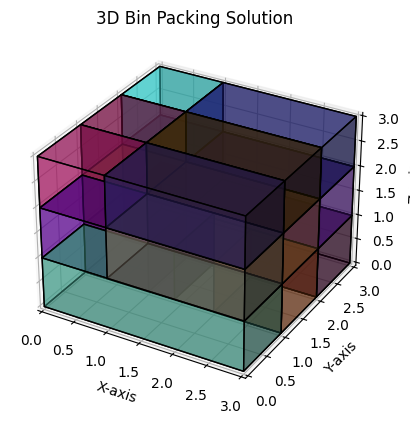

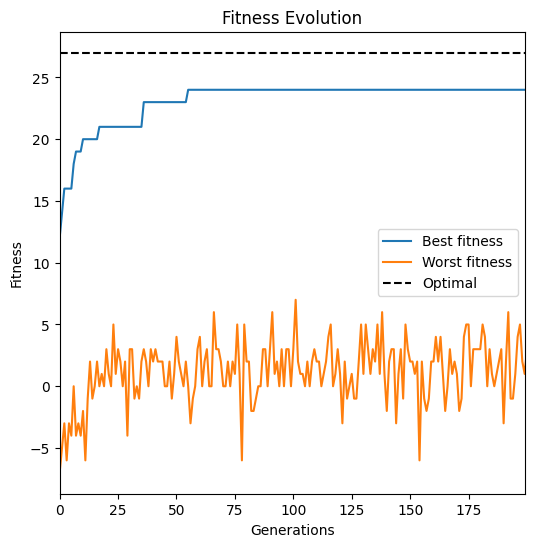

In [32]:
population, generations, fit, best_fits, worst_fits, fit_lim = run_evolution(pop_size=50, generation_limit=200, num_mutation=2, mutation_probability=0.5)

print('number of generations: ', generations)
print('items: ', items)
print('best solution: ', population[0])
print('best fitness: ', fit)
print('maximum fitness = ',fit_lim)
plot_configuration_3d(population[0], items, multi_color=True)
plot_fitness(best_fits, worst_fits, generations, fit_lim)

In [42]:
plot_configuration_3d_interactive(population[0], items)